# Laboratorium 4

### Konfiguracja

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.005

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [21]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None

    def get_added_rects(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


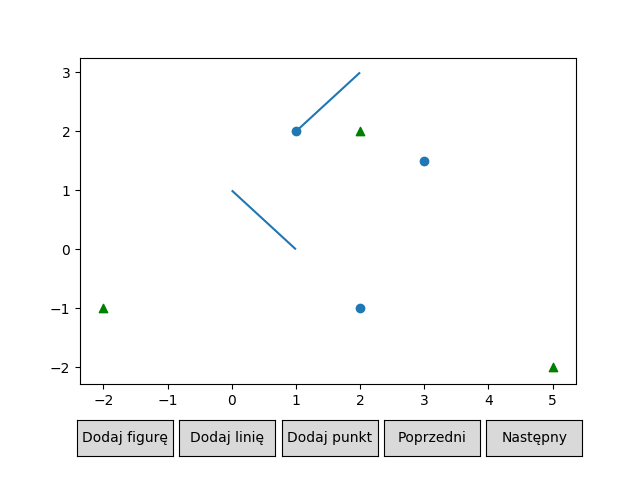

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


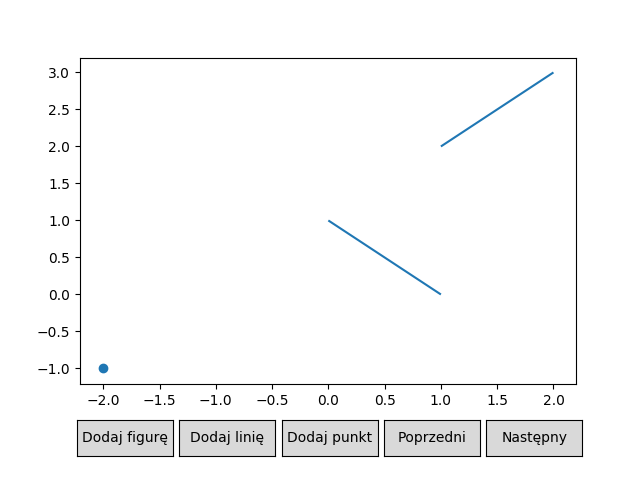

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [51]:
# #Dodaj tu punkty, figury i/lub odcinki!
# plot1 = Plot()
# plot1.draw()

In [52]:
# plot2 = Plot([plot1.get_added_elements()])
# print(plot1.get_added_rects()[0].lines)
# for lines_collection in plot1.get_added_rects():
#     print(lines_collection.lines)
# plot2.draw()

# Rozwiązanie

### Klasy

In [22]:
class Point:
    def __init__(self, point_tuple):
        self.coords = point_tuple
        self.type = None # typy wierzchołków: "original" - początkowy, "eventual" - końcowy,
                         #"connective" - łączący, "divisive" - dzielący, "right" - prawidłowy
        self.side = None
    
    def __eq__(self, other):
        return self.coords == other.coords
    
    def __gt__(self, other):
        return self.coords[1] > other.coords[1] or (self.coords[1] == other.coords[1] and self.coords[0] > other.coords[0])
    
    def __lt__(self, other):
        return self.coords[1] < other.coords[1] or (self.coords[1] == other.coords[1] and self.coords[0] < other.coords[0])
    
    def __getitem__(self, index):
        return self.coords[index]
    
    def set_type(self, point_type):
        self.type = point_type
        
    def set_side(self, point_side):
        self.side = point_side
            
    def to_tuple(self):
        return self.coords

class Polygon:
    def __init__(self, points, lines):
        self.points = points
        self.lines = lines
        self.top_point_inx = 0
        self.bottom_point_inx = 0
        
    def __getitem__(self, index):
        return self.points[index % len(self.points)]
    
    def get_len(self):
        return len(self.points)
    
    def get_top_point(self):
        return self[self.top_point_inx]
    
    def set_top_point(self, inx):
        self.top_point_inx = inx
        
    def get_bottom_point(self):
        return self[self.bottom_point_inx]
    
    def set_bottom_point(self, inx):
        self.bottom_point_inx = inx
        
    def print_points(self):
        print(list(map(Point.to_tuple, self.points)))
        
class Triangle: # zawsze ustawienie punktów w kierunku przeciwnym do ruchu wskazówek zegara
    def __init__(self, points):
        self.points = points
        self.lines = []
        self.lines.append([points[0].to_tuple(), points[1].to_tuple()])
        self.lines.append([points[1].to_tuple(), points[2].to_tuple()])
        self.lines.append([points[2].to_tuple(), points[0].to_tuple()])

### Funkcje

In [23]:
%matplotlib notebook

scenes = []

def make_polygon(plot): # tworzenie wielokąta z narysowanego w poprzedniej komórce
    points = []
    lines = []
    for line in plot.get_added_rects()[0].lines:
        points.append(Point(line[0]))
        lines.append(line)
    
    polygon = Polygon(points, lines)
    return polygon

def det(a, b, c): # 3x3 numpy
    a = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return np.linalg.det(a)

def draw_step_y_monotonicity(polygon, curr_points): # wizualizacja kroku algorytmu sprawdzania y-monotoniczności
    scenes.append(Scene([PointsCollection(curr_points.copy(), color='red')], 
                        [LinesCollection(polygon.lines, color='grey')]))
    
def draw_step_categorize(polygon, categorized_points): # wizualizacja kroku algorytmu klasyfikacji punktów
    original_points = []
    eventual_points = []
    connective_points = []
    divisive_points = []
    right_points = []
    
    for point in categorized_points:
        if point.type == "original":
            original_points.append(point)
        elif point.type == "eventual":
            eventual_points.append(point)
        elif point.type == "connective":
            connective_points.append(point)
        elif point.type == "divisive":
            divisive_points.append(point)
        elif point.type == "right":
            right_points.append(point)
    
    scenes.append(Scene([PointsCollection(original_points, color='green'), 
                         PointsCollection(eventual_points, color='red'),
                         PointsCollection(connective_points, color='navy'), 
                         PointsCollection(divisive_points, color='skyblue'),
                         PointsCollection(right_points, color='brown')], 
                        [LinesCollection(polygon.lines, color='grey')]))
    
def draw_step_triangulate(polygon, new_lines, curr_triangle): # wizualizacja kroku algorytmu triangulacji
    scenes.append(Scene([PointsCollection(polygon.points, color='grey')], 
                        [LinesCollection(polygon.lines, color='grey'),
                         LinesCollection(new_lines.copy(), color='green'),
                         LinesCollection(curr_triangle.lines, color='red')]))
    
def draw_triangulated(polygon, triangles): # wizualizacja po zakończonej triangulacji
    triangles_lines = []
    for triangle in triangles:
        for line in triangle.lines:
            triangles_lines.append(line)
    
    scenes.append(Scene([PointsCollection(polygon.points, color='grey')], 
                        [LinesCollection(triangles_lines, color='green')]))

### Y-monotoniczność

In [24]:
def find_min_max_y_points(polygon): # znajdowanie punktów o największej i najmniejszej współrzędnej y
    curr_top = 0
    curr_bottom = 0
    
    for i in range(1, polygon.get_len()):
        if polygon[i][1] > polygon[curr_top][1]:
            curr_top = i
            
        if polygon[i][1] < polygon[curr_bottom][1]:
            curr_bottom = i
    
    polygon.set_top_point(curr_top)
    polygon.set_bottom_point(curr_bottom)
    
def y_monotonicity(polygon, visualization=False):
    # znajdowanie punktów o największej i najmniejszej współrzędnej y (rezultat w obiekcie wielokąta)
    find_min_max_y_points(polygon)

    # indeksy punktów skrajnych
    curr_inx = polygon.top_point_inx + 1
    bottom_inx = polygon.bottom_point_inx
    
    if visualization:
        checked_points = [polygon[curr_inx - 1]]
        draw_step_y_monotonicity(polygon, checked_points)
    
    # sprawdzanie y-monotoniczności idąc po lewym łańcuchu
    while polygon[curr_inx] != polygon[bottom_inx]:
        if polygon[curr_inx] > polygon[curr_inx - 1]:
            return False
        
        if visualization:
            checked_points.append(polygon[curr_inx])
            draw_step_y_monotonicity(polygon, checked_points)
            
        curr_inx += 1
        
    curr_inx = polygon.top_point_inx -1
    
    # sprawdzanie y-monotoniczności idąc po prawym łańcuchu
    while polygon[curr_inx] != polygon[bottom_inx]:
        if polygon[curr_inx] > polygon[curr_inx + 1]:
            return False
        
        if visualization:
            checked_points.append(polygon[curr_inx])
            draw_step_y_monotonicity(polygon, checked_points)
            
        curr_inx -= 1
    
    return True

### Segregacja punktów

In [25]:
def categorize(polygon, visualization=False):
    if visualization:
        set_points = []
    
    for inx in range(polygon.get_len()+1):
        if polygon[inx-1][1] < polygon[inx][1] and polygon[inx+1][1] < polygon[inx][1]:
            if det(polygon[inx-1], polygon[inx], polygon[inx+1]) > 0: # wierzchołek początkowy
                polygon[inx].set_type("original")
            elif det(polygon[inx-1], polygon[inx], polygon[inx+1]) < 0: # wierzchołek dzielący
                polygon[inx].set_type("divisive")
        elif polygon[inx-1][1] > polygon[inx][1] and polygon[inx+1][1] > polygon[inx][1]:
            if det(polygon[inx-1], polygon[inx], polygon[inx+1]) > 0: # wierzchołek końcowy
                polygon[inx].set_type("eventual")
            elif det(polygon[inx-1], polygon[inx], polygon[inx+1]) < 0: # wierzchołek łączący
                polygon[inx].set_type("connective")
        else: # wierzchołek prawidłowy
            polygon[inx].set_type("right")
        
        if visualization:
            draw_step_categorize(polygon, set_points)
            set_points.append(polygon[inx])

### Triangulacja

In [26]:
def chain_categorization(polygon): # klasyfikacja punktów ze względu na przynależność do prawego bądź lewego łańcucha
    curr_inx = polygon.top_point_inx
    bottom_inx = polygon.bottom_point_inx
    
    polygon[curr_inx].set_side("t") # specjalnie oznaczenia dla wierzchołków skrajnych
    polygon[bottom_inx].set_side("b")
    
    curr_inx += 1
    
    # lewy łańcuch
    while polygon[curr_inx] != polygon[bottom_inx]:
        polygon[curr_inx].set_side("l")
        curr_inx += 1
    
    curr_inx = polygon.top_point_inx - 1
    
    # prawy łańcuch
    while polygon[curr_inx] != polygon[bottom_inx]:
        polygon[curr_inx].set_side("r")
        curr_inx -= 1
        

def inside_polygon(a, b, c, side): # sprawdzanie czy trójkąt jest wewnątrz wielokąta
    if side == "l":
        return det(a, b, c) < 0
    else:
        return det(a, b, c) > 0
    
def to_visualise(polygon, triangles, new_lines, new_triangle): # do wizualicji kroku algorytmu
    triangles.append(new_triangle)
    
    for line in new_triangle.lines:
        new_lines.append(line)
    
    draw_step_triangulate(polygon, new_lines, new_triangle)
        
def triangulate(polygon, visualization=False):
    # znajdowanie punktów o największej i najmniejszej współrzędnej y (rezultat w obiekcie wielokąta)
    find_min_max_y_points(polygon)
    
    # klasyfikacja punktów ze względu na przynależność do prawego bądź lewego łańcucha
    chain_categorization(polygon)
    
    # sortowanie po współrzędnej y-owej
    polygon.points.sort(reverse=True)
    
    # rezultat traingulacji - wszystkie trójkąty w wielokącie
    triangles = []
    
    # stos
    stack = []
    
    if visualization:
        new_lines = []
    
    stack.append(polygon[0])
    stack.append(polygon[1])
    
    for i in range(2, polygon.get_len()):
        curr_point = polygon[i]
        last_point = stack.pop()
        
        if curr_point.side !=  last_point.side: # dla wierzchołków z różnych łancuchów
            third_point = last_point
            
            while stack:
                second_point = third_point
                third_point = stack.pop()
                
                if curr_point.side == "l": # lewy łańcuch
                    new_triangle = Triangle([curr_point, second_point, third_point])
                    triangles.append(new_triangle)
                    
                    if visualization:
                        to_visualise(polygon, triangles, new_lines, new_triangle)
                        
                else: # prawy łańcuch
                    new_triangle = Triangle([curr_point, third_point, second_point])
                    triangles.append(new_triangle)
                    
                    if visualization:
                        to_visualise(polygon, triangles, new_lines, new_triangle)
                                     
            stack.append(last_point)
            stack.append(curr_point)
            
        else: # dla wierzchołków z tego samego łańcucha
            third_point = last_point
            
            # wierzchołki, z którymi nie stworzono nowego odcinka
            to_stack = []
            
            while stack:
                second_point = third_point
                third_point = stack.pop()
                                     
                if curr_point.side == "l": # lewy łańcuch
                    if inside_polygon(curr_point, second_point, third_point, "l"): # nowy odcinek wewnątrz wielokąta
                        new_triangle = Triangle([curr_point, second_point, third_point])
                        triangles.append(new_triangle)
                    
                        if visualization:
                            to_visualise(polygon, triangles, new_lines, new_triangle)
                            
                    else: # potencjalny nowy odcinek na zewnątrz wielokąta
                        to_stack.append(second_point)
                        
                else: # prawy łańcuch
                    if inside_polygon(curr_point, second_point, third_point, "r"): # nowy odcinek wewnątrz wielokąta
                        new_triangle = Triangle([curr_point, third_point, second_point])
                        triangles.append(new_triangle)
                    
                        if visualization:
                            to_visualise(polygon, triangles, new_lines, new_triangle)
                            
                    else: # potencjalny nowy odcinek na zewnątrz wielokąta
                        to_stack.append(second_point)
            
            stack.append(third_point)
            while to_stack:
                stack.append(to_stack.pop())
            stack.append(curr_point)
    
    if visualization:
        draw_triangulated(polygon, triangles)
        
    return triangles
                

# Wykonanie algorytmów

### Pusty układ współrzędnych

<IPython.core.display.Javascript object>


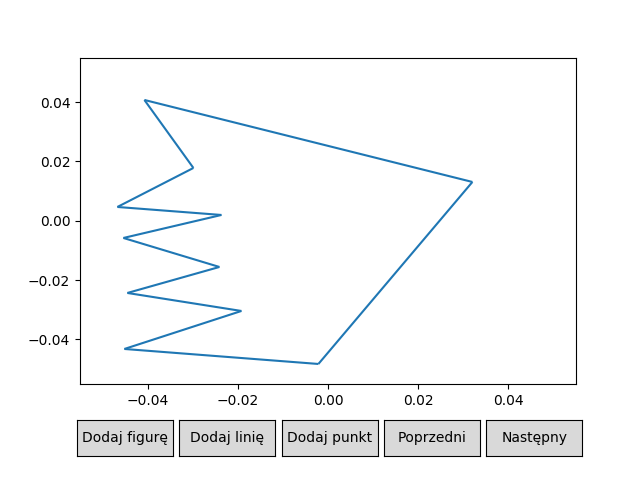

In [34]:
plot = Plot()
plot.draw()

### Y-monotoniczność

y-monotonic!


<IPython.core.display.Javascript object>


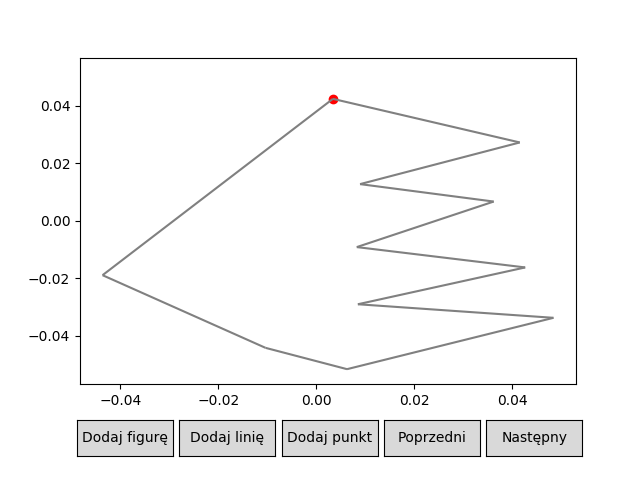

In [29]:
scenes = []
polygon = make_polygon(plot)

result = y_monotonicity(polygon, visualization=True)
if result:
    print("y-monotonic!")
else:
    print("not y-monotonic!")
    
plot2 = Plot(scenes)
plot2.draw()

### Segregacja punktów

<IPython.core.display.Javascript object>


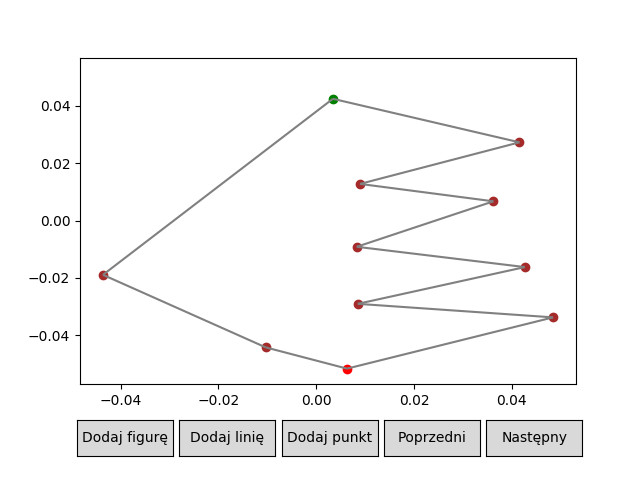

In [30]:
scenes = []
polygon = make_polygon(plot)

categorize(polygon, visualization=True)
    
plot2 = Plot(scenes)
plot2.draw()

### Triangulacja

<IPython.core.display.Javascript object>


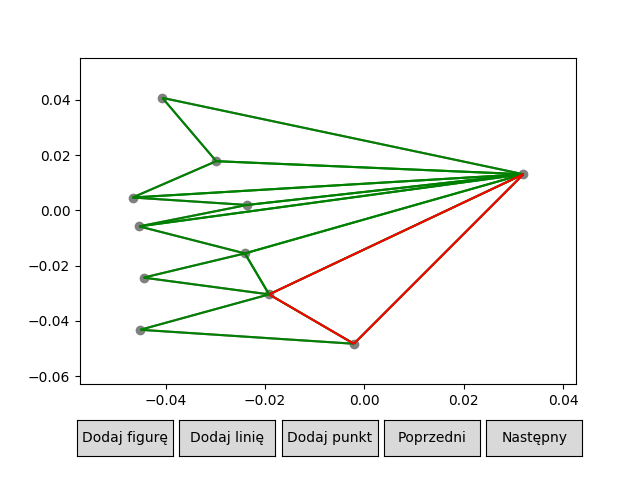

In [35]:
scenes = []
polygon = make_polygon(plot)

triangulate(polygon, visualization=True)

plot2 = Plot(scenes)
plot2.draw()